Title: Aggregate Building Load Model

Author: David P. Chassin

Project: Advanced Load Modeling (ALM)

Date: October 2021

# Introduction

This notebook documents the development of the ALM Aggregate Building Load Model, which is used to estimate the dynamic response of all the buildings on a feeder to various changes in conditions based on historical measurement of feeder load and outdoor air temperature.

The following Python modules are required.

In [1]:
from datetime import *
from dateutil import *
try:
    from control import *
    from control import matlab
    from matplotlib.pyplot import *
    from pandas import *
    from numpy import *
except:
    import pip
    pip.main("install control matplotlib numpy pandas slycot".split())
    raise Exception("try again")

# Building Load Model

The following diagram illustrates the system model.

The heat balance equations are
$$
    \dot T_{A} = 
        - { U_M+U_A \over C_A } T_A 
        + { U_M \over C_A } T_M 
        + { 1 \over C_A } Q_H
        + { U_A \over C_A } T_O
        + \dot T_S
        + { Q_I \over C_A }
$$
and
$$
    \dot T_{M} =
        + { U_A \over C_M } T_A
        - { U_M+U_O \over C_M } T_M
        + { U_O \over C_M } T_O
        + \dot T_S
        + { 1 \over C_M } Q_S.
$$

The heating (cooling) requirement is
$$
    Q_H = m (T_S - T_A)
$$
where $m$ is the system capacity is the current mode, e.g., 10,000 BTU/$^\circ$F.h. The change in heating (cooling) requirement is always
$$
    \dot Q_H = m ( \dot T_S - \dot T_A )
$$
or
$$
    \dot Q_H = 
        + m { U_M+U_A \over C_A } T_A 
        - m { U_M \over C_A} T_M
        - m { U_A \over C_A } T_O
        - m { 1 \over C_A } Q_I    
$$

The equilibrium temperature when the system is off is
$$
     T_E = { Q_I \over U_A } + { Q_S \over U_O } + T_O
$$

# Test model

Test the model using the following conditions.

In [2]:
UA = 500.0 # BTU/degF.h
CA = 5000.0 # BTU/degF
UM = 1000.0 # BTU/degF.h
CM = 10000.0 # BTU/degF
UO = 500.0 # BTU/degF.h
m = -10000.0 # BTU/h
QI = +1*3412.0 # BTU/h
QS = +1*3412.0 # BTU/h

In [3]:
TS = 72.0 # degF
TO = 95.0 # degF
DB = 1.0 # degF

Compute the system-off equilibrium temperature and the expected system mode.

In [4]:
TE = QI/UA + QS/UO + TO
if TO < 20:
    mode = "AUX"
    eta = +1.0 * 3412
elif abs(TE-TS) < DB:
    mode = "VENT"
    eta = +0.1 * 3412
elif TE > TS:
    mode = "COOL"
    eta = -3.0 * 3412
else:
    mode = "HEAT"
    eta = +4.0 * 3412
TE,mode

(108.648, 'COOL')

Compute the canonical continuous system state-space model matrices for $\mathbf{x}=\left[\begin{matrix}T_A&T_M&Q_H\end{matrix}\right]^T$, $\mathbf{u}=\left[\begin{matrix}T_O&\dot T_S&Q_I&Q_S\end{matrix}\right]^T$, and $\mathbf{y}$ is the total power.
$$
    \mathbf{A} = \left[ \begin{matrix}
        -{ U_M+U_A \over C_A } & { U_M \over C_A } & { 1 \over C_A }
    \\
        { UM \over C_M } & -{ U_M+U_O \over C_M } & 0
    \\
        m { U_M+U_A \over C_A } & -m { U_M \over C_A } & 0
    \end{matrix} \right]
\qquad
    \mathbf{B} = \left[ \begin{matrix}
        { U_A \over C_A } & 1 & { 1 \over C_A } & 0
    \\
        { U_O \over C_M } & 1 & 0 & { 1 \over C_M }
    \\
        -m { U_A \over C_A } & 0 & - { m \over C_A } & 0
    \end{matrix} \right]
$$

$$
    \mathbf{C} = \left[ \begin{matrix}
        0 & 0 & - { 1 \over \eta }
    \end{matrix} \right]
\qquad
    \mathbf{D} = \left[ \begin{matrix}
        0 & 0 & { 1 \over 3412 } & 0 
    \end{matrix} \right]
$$ 

In [5]:
A = [[-(UM+UA)/CA, UM/CA, 1/CA],
     [UM/CM, -(UM+UO)/CM, 0],
     [m*(UM+UA)/CA, -m*UM/CA, 0]
    ]
B = [[UA/CA, 1, 1/CA, 0],
     [UO/CM, 1, 0, 1/CM],
     [-m*UA/CA, 0, -m/CA, 0]
    ]
C = [[0, 0, -1/eta]]
D = [[0, 0, 1/3412.0, 0]]

Compute the discrete time state-space model.

In [6]:
G = ss(A,B,C,D,timeunit='h')
H = c2d(G,1)
H

StateSpace(array([[ 5.19114296e-01,  3.08907577e-01,  1.56842468e-04],
       [ 7.22564325e-02,  8.74091012e-01,  8.21973558e-06],
       [-2.27043967e+03,  1.44512865e+03,  7.46158263e-01]]), array([[ 1.71978127e-01,  9.24407054e-01,  3.29936783e-04,
         1.40194712e-05],
       [ 5.36525553e-02,  9.73955071e-01,  1.40194712e-05,
         9.32856393e-05],
       [ 8.25311020e+02, -4.47235127e+02,  1.56842468e+00,
         8.21973558e-02]]), array([[0.00000000e+00, 0.00000000e+00, 9.76944119e-05]]), array([[0.        , 0.        , 0.00029308, 0.        ]]), 1)

Verify that the system is stable.

In [7]:
if any(list(map(lambda x: x.real>=1,pole(H)))): raise Exception("WARNING: system is not stable")

# System analysis

Analyse the $T_O$ step response.

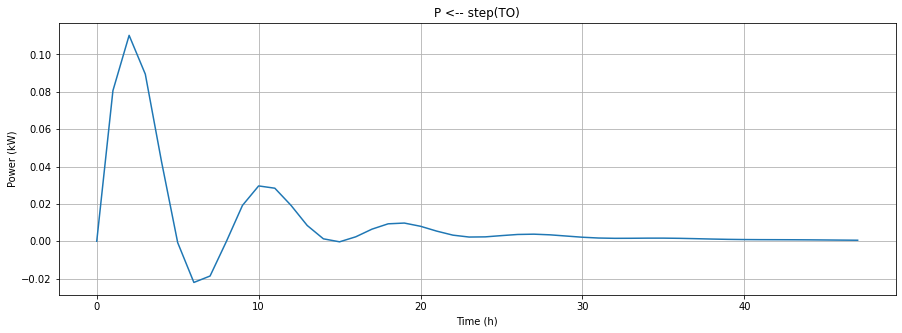

In [8]:
T,P,X = step_response(H,T=arange(0,48,1),return_x=True)
figure(1,figsize=(15,5))
plot(T,P[0,0])
title("P <-- step(TO)")
xlabel('Time (h)')
ylabel('Power (kW)')
grid()

Analyse the $\dot T_S$ impulse response.

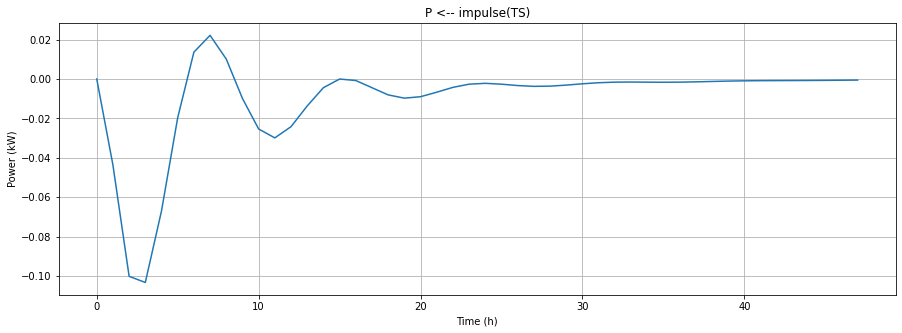

In [9]:
T,P,X = impulse_response(H,T=arange(0,48,1),return_x=True)
figure(1,figsize=(15,5))
plot(T,P[0,1])
title("P <-- impulse(TS)")
xlabel('Time (h)')
ylabel('Power (kW)')
grid()

# Transfer function

The $z$-domain transfer function from $T_O$ to $P$ can be written as
$$
    { P(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{P}_{t} = 
        + b_2 \mathbf{T}_{t-2} 
        + b_1 \mathbf{T}_{t-1} 
        + b_0 \mathbf{T}_{t} 
        - a_3 \mathbf{P}_{t-3} 
        - a_2 \mathbf{P}_{t-2} 
        - a_1 \mathbf{P}_{t-1}
$$
where $t \in (4,K)$, and $\mathbf P$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, this can be written in the form
$$
    \mathbf{M} \mathbf{x} = \mathbf{P}_{t}
$$
where $\mathbf{M} \in \mathbb{R}^{K-3\times6}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-3} & \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} b_2 & b_1 & b_0 & -a_2 & -a_1 & -a_0 \end{matrix} \right]^T
$$
Solve for $\mathbf x$.
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{P}_{t}.
$$
This solution can also be obtained efficiently using the Python SciPy `linalg.solve` function.

## Example

Test on feeder data and weather data.

First load the power data. The data is subhourly, so the hourly average power must be computed.

In [10]:
feeder_power = read_csv("feeder_power.csv")
index = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),DatetimeIndex(feeder_power.timestamp)))
power = feeder_power.groupby(index).feeder_power.mean()

Then load the temperature data and join it with the power data.

In [11]:
def temperature(x):
    try:
        return round(float(x),1)
    except:
        return float('NAN')
def isodatetime(x):
    return datetime.strptime(x,"%Y-%m-%dT%H:%M:%S")
feeder_weather = read_csv("feeder_weather.csv",
                    converters={
                      "DATE":isodatetime,
                      "HourlyDryBulbTemperature":temperature,
                      "HourlyDewPointTemperature":temperature,
                    },
                    usecols = ["DATE","HourlyDryBulbTemperature","HourlyDewPointTemperature"],
                    keep_default_na = False,
                    index_col = ["DATE"])
index = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),feeder_weather.index))
feeder = feeder_weather.groupby(index).mean().join(power.round(1)).dropna()
feeder.columns = ["dewpoint","temperature","power"]
feeder.index.name = "datetime"
# TODO: compute heat-index so we account for latent load better

Identify the load model.

In [12]:
L = 3 # order of model
K = len(feeder.power)
N = int(8760/12) # hours of data to hold out
P = matrix(feeder.power).transpose()
T = matrix(feeder.temperature).transpose()
M = hstack([hstack([P[n:K-L+n] for n in range(L)]),
            hstack([T[n+1:K-L+n+1] for n in range(L)])])
Mh = M[0:-N]
Mt = Mh.transpose()
x = linalg.solve(matmul(Mt,Mh),matmul(Mt,P[L:-N]))
Q = M[-N:]*x

Verify the load model on hold out data

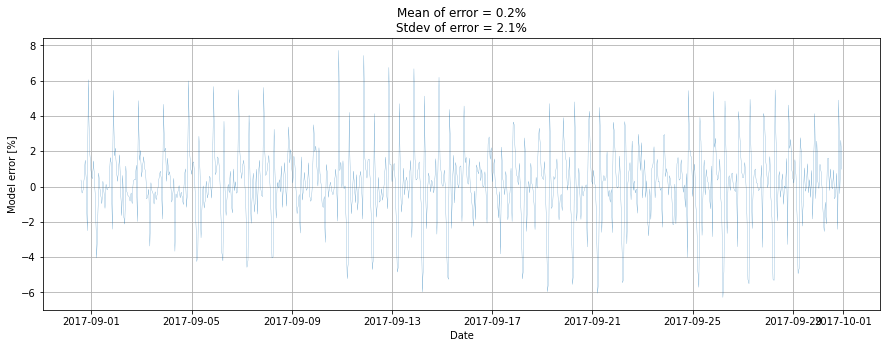

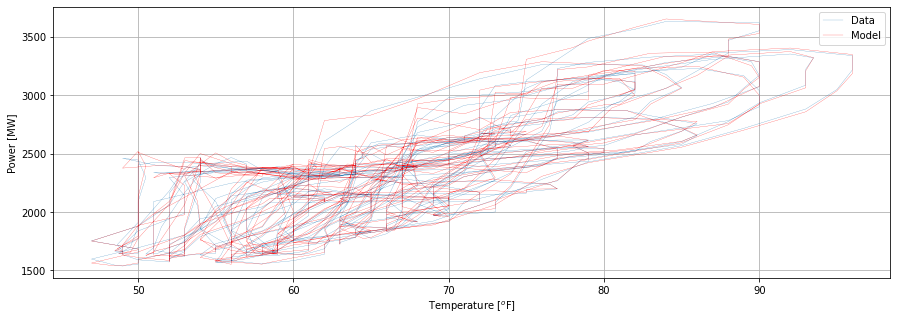

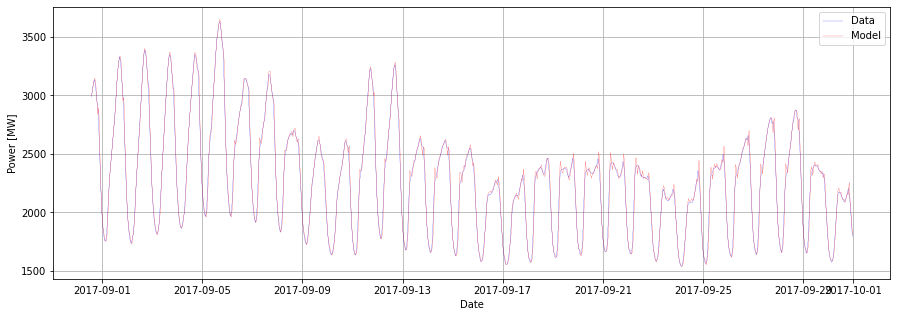

In [13]:
figure(2,figsize=(15,5))
e = Q/P[-N:]-1
t = feeder.index
plot(t[-N:],e*100,linewidth=0.2)
grid()
xlabel("Date")
ylabel("Model error [%]")
title(f'Mean of error = {e.mean()*100:.1f}%\nStdev of error = {e.std()*100:.1f}%')
show()

figure(1,figsize=(15,5))
plot(T[-N:],feeder.power[-N:],linewidth=0.2,label="Data")
plot(T[-N:],Q,'-r',linewidth=0.2,label="Model")
grid()
xlabel('Temperature [$^o$F]')
ylabel('Power [MW]')
legend()
show()

figure(1,figsize=(15,5))
plot(t[-N:],P[-N:],'-b',linewidth=0.2,label="Data")
plot(t[-N:],Q,'-r',linewidth=0.2,label="Model")
grid()
xlabel('Date')
ylabel('Power [MW]')
legend()
show()

Sometimes we require a model that uses only the inputs.

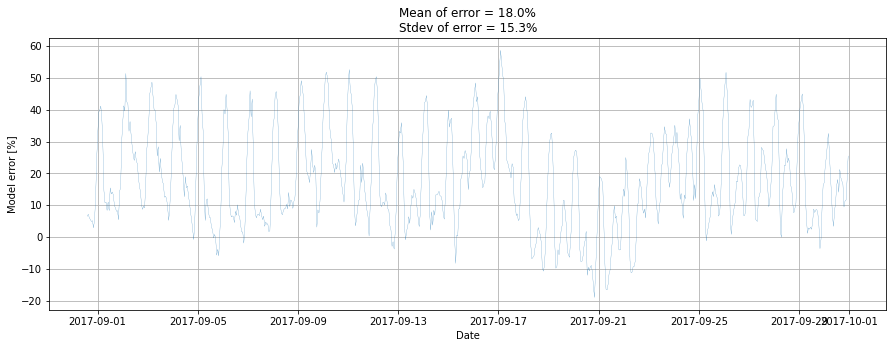

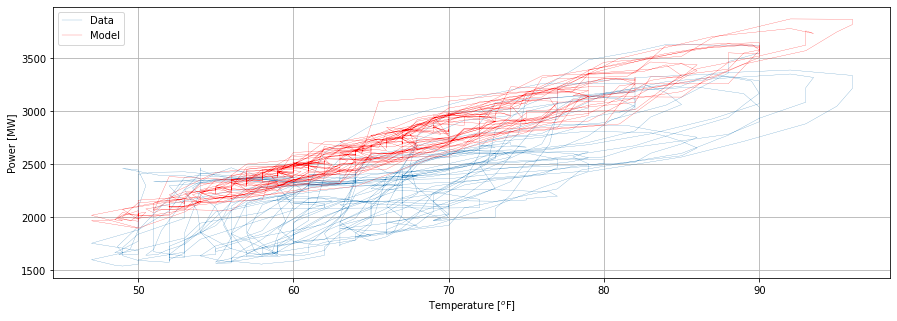

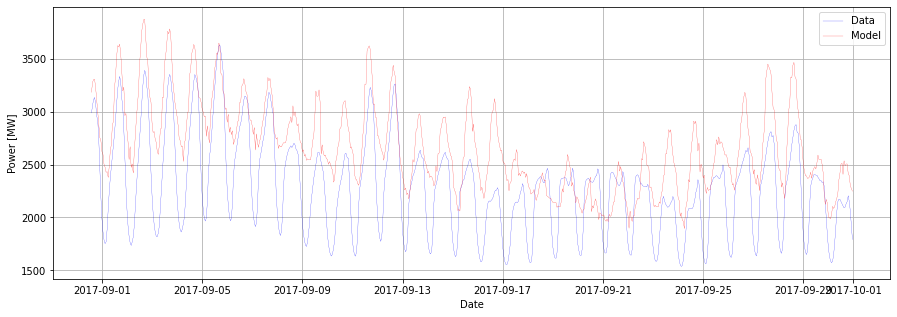

In [14]:
L = 3 # order of model
M = hstack([T[L-n:-n-1] for n in range(L)])
Mh = M[0:-N]
Mt = Mh.transpose()
x = linalg.solve(matmul(Mt,Mh),matmul(Mt,P[L+1:-N]))
Q = M[-N:]*x

figure(figsize=(15,5))
e = Q/P[-N:]-1
t = feeder.index
plot(t[-N:],e*100,linewidth=0.2)
grid()
xlabel("Date")
ylabel("Model error [%]")
title(f'Mean of error = {e.mean()*100:.1f}%\nStdev of error = {e.std()*100:.1f}%')
show()

figure(figsize=(15,5))
plot(T[-N:],feeder.power[-N:],linewidth=0.2,label="Data")
plot(T[-N:],Q,'-r',linewidth=0.2,label="Model")
grid()
xlabel('Temperature [$^o$F]')
ylabel('Power [MW]')
legend()
show()

figure(figsize=(15,5))
plot(t[-N:],P[-N:],'-b',linewidth=0.2,label="Data")
plot(t[-N:],Q,'-r',linewidth=0.2,label="Model")
grid()
xlabel('Date')
ylabel('Power [MW]')
legend()
show()

# Including solar data

Solar data was obtained from https://maps.nrel.gov/nsrdb-viewer/?aL=x8CI3i%255Bv%255D%3Dt%26Jea8x6%255Bv%255D%3Dt%26Jea8x6%255Bd%255D%3D1%26VRLt_G%255Bv%255D%3Dt%26VRLt_G%255Bd%255D%3D2%26mcQtmw%255Bv%255D%3Dt%26mcQtmw%255Bd%255D%3D3&bL=clight&cE=0&lR=0&mC=45.612596491395976%2C-122.70724296569824&zL=14 for 2014-2017.

In [210]:
attributes = 'ghi,dhi,dni,cloud_type,dew_point,air_temperature,surface_albedo,wind_speed,wind_direction,solar_zenith_angle'

leap = True
interval = 60
utc = "true"

name = "David Chassin".replace(" ","+")
org = "SLAC National Accelerator Laboratory".replace(" ","+")
reason = "Load modeling".replace(" ","+")
email="gridlabd@gmail.com"
notify = "false"

import json, sys, os, urllib
with open(f"{os.getenv('HOME')}/.nsrdb/api_key.json","r") as f: 
    api = json.load(f)[email]

def get_data(year,lat,lon):
    url = f"https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={str(leap).lower()}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={org}&mailing_list={notify}&reason={reason}&api_key={api}&attributes={attributes}"
    if lat > 0: lat = f"N{lat:.2f}"
    elif lat < 0: lat = f"S{-lat:.2f}"
    else: lat = "0"
    if lon > 0: lon = f"E{lon:.2f}"
    elif lon < 0: lon = f"W{-lon:.2f}"
    else: lon = "0"
    cache = f"nsrbd_{lat}_{lon}_{year}.csv"
    try:
        result = read_csv(cache,nrows=1).to_dict(orient="list")
        result.update(dict(Year=[year],DataFrame=[read_csv(cache,skiprows=2)]))
    except:
        with urllib.request.urlopen(url) as fin:
            with open(cache,"w") as fout:
                fout.write(fin.read().decode("utf-8"))
        result = read_csv(cache,nrows=1).to_dict(orient="list")
        result.update(dict(Year=[year],DataFrame=[read_csv(cache,skiprows=2)]))
    for data in result["DataFrame"]:
        data["datetime"] = list(map(lambda x: datetime(x[0,0],x[0,1],x[0,2],x[0,3],0,0),matrix([data.Year,data.Month,data.Day,data.Hour]).transpose()))
        data.set_index("datetime",inplace=True)
        data.drop(columns=["Year","Day","Month","Hour","Minute"],inplace=True)
        data.columns = ["solar_global","solar_horizontal","solar_direct","clouds","dewpoint","temperature","albedo","wind_speed","wind_direction","solar_altitude"]
    return result

def get_info(year,lat,lon):
    return read_csv(url,nrows=1)
    
def get_weather(year,info):
    lat = info["Latitude"][0]
    lon = info["Longitude"][0]
    url = f"https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={org}&mailing_list={notify}&reason={reason}&api_key={api}&attributes={attributes}"
    data = read_csv(url,skiprows=2)
    data["datetime"] = list(map(lambda x: datetime(x[0,0],x[0,1],x[0,2],x[0,3],0,0),matrix([data.Year,data.Month,data.Day,data.Hour]).transpose()))
    data.set_index("datetime",inplace=True)
    data.drop(columns=["Year","Day","Month","Hour","Minute"],inplace=True)
    data.columns = ["solar_global","solar_horizontal","solar_direct","clouds","dewpoint","temperature","albedo","wind_speed","wind_direction","solar_altitude"]

    return data

get_data(2014,45.621638,-122.699997)

{'Source': ['NSRDB'],
 'Location ID': [216897],
 'City': ['-'],
 'State': ['-'],
 'Country': ['-'],
 'Latitude': [45.61],
 'Longitude': [-122.7],
 'Time Zone': [0],
 'Elevation': [10],
 'Local Time Zone': [-8],
 'Clearsky DHI Units': ['w/m2'],
 'Clearsky DNI Units': ['w/m2'],
 'Clearsky GHI Units': ['w/m2'],
 'Dew Point Units': ['c'],
 'DHI Units': ['w/m2'],
 'DNI Units': ['w/m2'],
 'GHI Units': ['w/m2'],
 'Solar Zenith Angle Units': ['Degree'],
 'Temperature Units': ['c'],
 'Pressure Units': ['mbar'],
 'Relative Humidity Units': ['%'],
 'Precipitable Water Units': ['cm'],
 'Wind Direction Units': ['Degrees'],
 'Wind Speed': ['m/s'],
 'Cloud Type -15': [nan],
 'Cloud Type 0': ['Clear'],
 'Cloud Type 1': ['Probably Clear'],
 'Cloud Type 2': ['Fog'],
 'Cloud Type 3': ['Water'],
 'Cloud Type 4': ['Super-Cooled Water'],
 'Cloud Type 5': ['Mixed'],
 'Cloud Type 6': ['Opaque Ice'],
 'Cloud Type 7': ['Cirrus'],
 'Cloud Type 8': ['Overlapping'],
 'Cloud Type 9': ['Overshooting'],
 'Cloud Type 

In [206]:
get_data

<function __main__.get_data(year, lat, lon)>

In [188]:
data = []
for year in range(2014,2018):
    data.append(get_weather(year,info))
data = concat(data)


In [112]:
data.columns = ["solar_global","solar_horizontal","solar_direct","clouds","dewpoint","temperature","albedo","wind_speed","wind_direction","solar_altitude"]
data

,solar_global,solar_horizontal,solar_direct,clouds,dewpoint,temperature,albedo,wind_speed,wind_direction,solar_altitude
datetime,,,,,,,,,,
2014-01-01 00:00:00,0,0,0,4,4,6,0.092,0.4,148.9,89.81
2014-01-01 01:00:00,0,0,0,4,4,6,0.092,0.5,162.0,98.98
2014-01-01 02:00:00,0,0,0,1,4,6,0.092,0.5,153.0,108.89
2014-01-01 03:00:00,0,0,0,4,4,6,0.092,0.5,140.3,119.23
2014-01-01 04:00:00,0,0,0,0,4,6,0.092,0.4,128.9,129.70
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,343,71,772,1,1,5,0.088,1.3,73.6,69.37
2017-12-31 20:00:00,355,71,782,1,1,6,0.088,1.2,71.3,68.73
2017-12-31 21:00:00,315,68,751,7,1,6,0.088,1.1,63.5,70.77


# Application to Forecasting

Test forecasting the all-time peak.

In [15]:
str(feeder[feeder.power==feeder.power.max()].index.to_pydatetime()[0])

'2017-08-03 16:00:00'

In [16]:
t0 = feeder[feeder.temperature==feeder.temperature.max()].index.to_pydatetime()[0] - timedelta(hours=24)
hours = 48

def forecast(sys,t0,dt,nt,P,T):
    t1 = t0 + dt*nt
    yy = []
    p = P[t0-3*dt:t0-dt].tolist()
    for t in date_range(t0,t0+dt*nt,nt+1):
        x = hstack([p,T[t-2*dt:t]])
        y = matmul(x,sys).tolist()[0][0]
        yy.append(y)
        p = p[1:]
        p.append(y)
    result = DataFrame(yy,date_range(t0,t0+dt*nt,nt+1),columns=["forecast"])
    result.index.name = "datetime"
    return result

R = forecast(x,t0,timedelta(hours=1),hours,feeder.power,feeder.temperature).join(feeder.power)
figure(3,figsize=(15,10))
plot(R.index,R["forecast"],label="Forecast power")
plot(R.index,R["power"],label="Actual power")
grid()
legend()
show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 6)

# Hidden state and input estimation

Only the value of $T_O$ is known.  The state variables $T_A$, $T_M$, and $Q_H$ are not observed. In addition the inputs $\dot T_S$ and $Q_I$ are not known, and the input $Q_S$ is known with only limited certainty.  The values of $x = [T_A,T_M,Q_H]^T$ should have the smallest variation, and among the inputs $u=[T_O,\dot T_S,Q_I,Q_S]$, the values of $u_2=\dot T_S$ should change as little as possible, the values of $u_3=Q_I$ should be as small as possible, and the values of $u_4$ should be a close to $Q_S$ as possible.

We therefore define an optimization problem designed to identify these unknowns.

$\qquad \min ||x||_2^2 + \lambda_1||u_2||_1 + \lambda_2||u_3||_2^2 + \lambda_3||u_4-Q_S||_2^2$

s.t.

$\qquad x_{t+1} = A_{t} x_{t} + B_{t} u_{t}$

$\qquad P_{t} = C_{t} x_{t} + D_{t} u_{t}$

$\qquad x_0 = [T_S,T_S,0]^T$

$\qquad u_1 = T_0$

for $t \in (1,T-1)$